# Packages

In [2]:
using Pkg; Pkg.activate("."); 
using TSO
using PyPlot
using Glob
using Serialization

  Activating environment at `/cobra/u/peitner/Turbospectrum/opacity_tables/TSO.jl/examples/converting_tables/Project.toml`


# Loading the Tables

In [3]:
paths = glob("OS_table*", "OPAC-for-3D/Z0.0a0.0");

In [4]:
mos = TSO.MARCSOpacity(paths...);

In [5]:
eos = TSO.reload(TSO.SqEoS, abspath("../../../tests/TSO_sun_Magg_v10.2/eos.hdf5"));

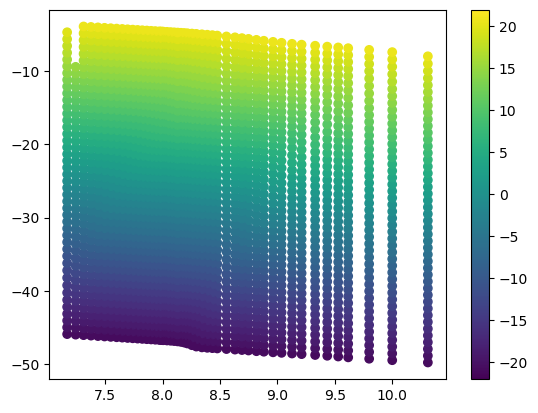

In [6]:
close()

for i in eachindex(mos)
    plt.scatter(log.(mos[i].T), log.(mos[i].ρ), c=log.(mos[i].pg), vmin=-22, vmax=22)
end

#plt.yscale("log")
#plt.xscale("log")
plt.colorbar()
gcf()

In [32]:
function square(mos, eos)
    lnT    = common_grid_test(mos..., which=:T)
    lnR    = common_grid_test(mos..., which=:ρ)

    eos_int, opa_int... = reshape_test(mos, eos) # long list of all points, scattered

    return (eos_int, lnT, lnR, opa_int...)
end

function interp(eos_int, lnT, lnR, opa_int...)
    eos_final, opa_final... = interpolate_final(eos_int, opa_int...; lnT=lnT, lnR=lnR)

    (eos, opa_final...)
end

function lookup_function_scatter(aos, which)
    if !TSO.scipy_loaded[]
        TSO.load_scipy_interpolate!()
    end

    TSO.ScatteredLookup(TSO.scipy_interpolate.LinearNDInterpolator(zip_collect(EnergyAxis(aos).values, DensityAxis(aos).values), getfield(aos.eos, which)))
end

function lookup_function_scatter(aos, opa, which, i)
    if !TSO.scipy_loaded[]
        TSO.load_scipy_interpolate!()
    end

    ip = TSO.scipy_interpolate.LinearNDInterpolator(zip_collect(EnergyAxis(aos).values, DensityAxis(aos).values), log.(view(getfield(opa, which), :, i)))

    TSO.ScatteredLookup((x,y)->exp.(ip(x,y)))
end

zip_collect(x, y) = begin
    xy = zeros(eltype(x), length(x), 2)
    for i in eachindex(x)
        xy[i, 1] = x[i]
        xy[i, 2] = y[i]
    end

    xy
end

function interpolate_final(eos, opa...; lnT, lnR)
    # We can use the normal lookup function to interpolate to a new table
    aos = AxedEoS(eos, EnergyAxis(eos; axis=:lnT), DensityAxis(eos))

    nT   = length(lnT)
    nR   = length(lnR)

    T, R = TSO.meshgrid(lnT, lnR)

    neLF = lookup_function_scatter(aos, :lnNe)
    pgLF = lookup_function_scatter(aos, :lnPg)
    eiLF = lookup_function_scatter(aos, :lnEi)

    ne   = TSO.lookup(neLF, T, R)
    pg   = TSO.lookup(pgLF, T, R)
    ei   = TSO.lookup(eiLF, T, R)


    κ_c  = zeros(eltype(eos.lnPg), nT, nR, length(first(opa).λ), length(opa))
    S    = zeros(eltype(eos.lnPg), nT, nR, length(first(opa).λ))

    for i in eachindex(opa)
        for k in eachindex(opa[i].λ)
            κ_cLF  = lookup_function_scatter(aos, opa[i], :κ, k)
            κ_c[ :, :, k, i] .= TSO.lookup(κ_cLF,  T, R)

            if i==1
                sLF = lookup_function_scatter(aos, opa[i], :src, k)
                S[:, :, k] .= TSO.lookup(sLF, T, R)
            end
        end
    end

    return  TSO.RegularEoSTable(lnR, lnT, ei, pg, zeros(eltype(lnR), nT, nR), ne),
            TSO.RegularOpacityTable(κ_c[ :,:,:,1], zeros(eltype(lnR), nT, nR), S, opa[1].λ, false),
            TSO.RegularOpacityTable(κ_c[:,:,:,2],  zeros(eltype(lnR), nT, nR), S, opa[2].λ, false),
            TSO.RegularOpacityTable(κ_c[:,:,:,3],  zeros(eltype(lnR), nT, nR), S, opa[3].λ, false),
            TSO.RegularOpacityTable(κ_c[ :,:,:,4], zeros(eltype(lnR), nT, nR), S, opa[4].λ, false)
end

function reshape_test(mos, eos)
    nS   = sum((length(m.T) for m in mos))
    pe   = zeros(eltype(mos[1].T), nS)
    ne   = similar(pe)
    pg   = zeros(eltype(mos[1].T), nS)
    T    = zeros(eltype(mos[1].T), nS)
    R    = zeros(eltype(mos[1].T), nS)
    κ_c  = zeros(eltype(mos[1].T), nS, length(mos[1].λ))
    κ_s  = zeros(eltype(mos[1].T), nS, length(mos[1].λ))
    κ_la = zeros(eltype(mos[1].T), nS, length(mos[1].λ))
    κ_lm = zeros(eltype(mos[1].T), nS, length(mos[1].λ))
    S    = zeros(eltype(mos[1].T), nS, length(mos[1].λ))
    
    c = 1
    for m in mos
        for i in eachindex(m.T)
            pg[c] = log(m.pe[i])
            pe[c] = log(m.pg[i])
            ne[c] = log(exp(pe[c]) / (TSO.KBoltzmann .* m.T[i]))
            T[c]  = log(m.T[i])
            R[c]  = log(m.ρ[i])
            for k in eachindex(m.λ)
                κ_c[ c, k] = m.κ_c[ i, k]
                κ_s[ c, k] = m.κ_s[ i, k]
                κ_la[c, k] = m.κ_la[i, k]
                κ_lm[c, k] = m.κ_lm[i, k]
                S[c, k]    = TSO.Bν(m.λ[k], exp(T[i]))   
            end
            c+=1
        end
    end

    return  TSO.RegularEoSTable(R, T, lookup(@axed(eos), :lnEi, R, T), pg, zeros(eltype(mos[1].T), nS), ne),
            TSO.RegularOpacityTable(κ_c,  zeros(eltype(mos[1].T), nS), S, mos[1].λ, false),
            TSO.RegularOpacityTable(κ_la, zeros(eltype(mos[1].T), nS), S, mos[1].λ, false),
            TSO.RegularOpacityTable(κ_lm, zeros(eltype(mos[1].T), nS), S, mos[1].λ, false),
            TSO.RegularOpacityTable(κ_s,  zeros(eltype(mos[1].T), nS), S, mos[1].λ, false)
end

function common_grid_test(mos::MARCSOS...; which=:ρ)
    mi = minimum((minimum(getfield(m, which)) for m in mos))
    ma = maximum((maximum(getfield(m, which)) for m in mos))

    l  = cat([unique(getfield(m, which)) for m in mos]..., dims=1)
    range(log(mi), log(ma), length=length(l)) |> collect
end

common_grid_test (generic function with 1 method)

In [27]:
eos_int, lnT, lnR, opa_int... = square(mos, eos);

In [33]:
interp(eos_int, lnT, lnR, opa_int...)

# Complement with EoS

The MARCS OS tables do not provide internal energy, which is why they need to be complemented with an EoS to get it. Any EoS may be used. The rosseland opacity can either compute by itself (which should be the prefered procedure) or take it from the EoS aswell. The rest can either be taken from this table or from the original EoS.

In [43]:
eos = TSO.reload(TSO.SqEoS, abspath("../../../tests/TSO_sun_Magg_v10.2/eos.hdf5"));